In [3]:
source('../function.r')

In [4]:
library(anndata)

library(Seurat)

library("diptest")

library("mixtools")

library(ggplot2)


Attaching package: ‘anndata’


The following object is masked from ‘package:readr’:

    read_csv


Warning message:
“package ‘Seurat’ was built under R version 4.1.2”
Attaching SeuratObject



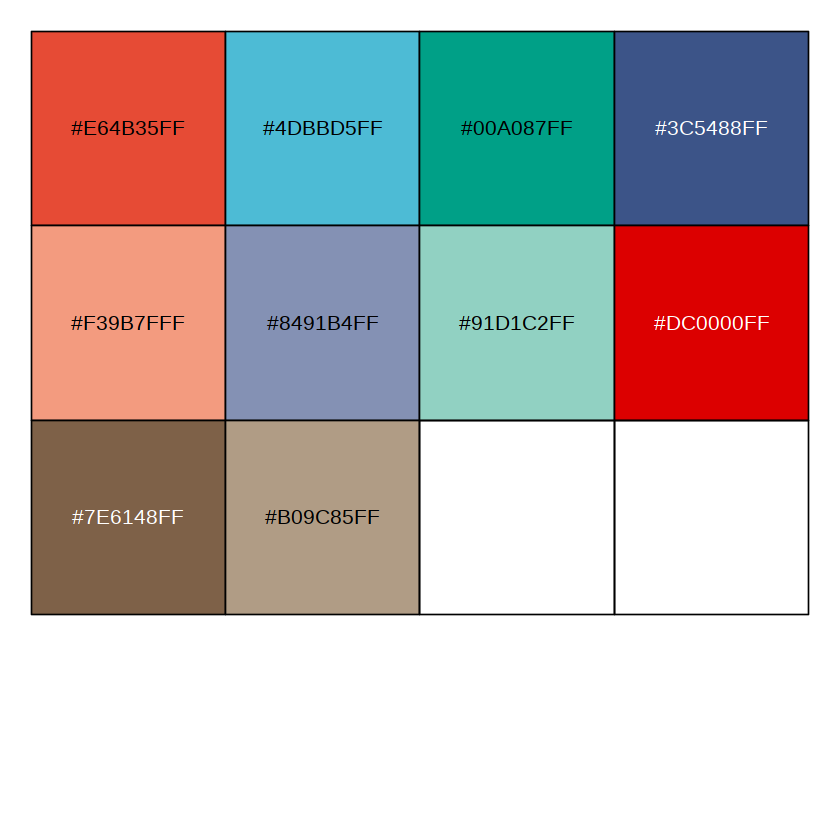

In [5]:
colors_ <- ggsci::pal_npg()(10)
scales::show_col(ggsci::pal_npg()(10))

In [6]:
scatter_style <- function(ggplot_,legend_position='none',xlab_='PC1',ylab_='PC2',title='',
                          x.angle=0,ratio=1){
    sp <- ggplot_+theme_classic()+  
        #border()+
#         xlab(xlab_)+
#         ylab(ylab_)+
        ggtitle(title)+
        theme(legend.position=legend_position,
              title=element_text(size = 8, face = "bold"),
              aspect.ratio = ratio, 
                axis.text.x = element_text(angle=x.angle,size = 8),
                axis.title.x = element_text(size = 8, face = "bold"),
                axis.text.y = element_text(size = 8),
                axis.title.y = element_text(size = 8, face = "bold"))
    return(sp)
}

# load data

In [7]:
data.norm <- readRDS('data/data_norm.k562vsRPE1.top2k.rds')

In [8]:
features.select <- readRDS('data/variable_genes.k562vsRPE1.top2k.rds')

In [9]:
meta.data <- readRDS('data/metadata.k562vsRPE1.top2k.rds')

# PCA transform

In [10]:
Z <- data.norm[features.select,]%>%t

In [11]:
Z.center <- apply(Z,2,function(x){x-mean(x)})

Z.shift <- colMeans(Z)

Z_pca_results <- prcomp(Z.center, retx = TRUE, center = TRUE, scale. = FALSE, tol = NULL, rank. = NULL)

In [12]:
#plot(Z_pca_results$x[,1:2],cex=0.2)

pc.number<-7

Z_PC_matrix <- Z_pca_results$x

Z_projection_genebypc <- Z_pca_results$rotation

In [13]:
set.seed(0)
Z_EM_results_d1 <- normalmixEM(Z_PC_matrix[,1])

number of iterations= 12 


In [14]:
labels <- (Z_EM_results_d1$posterior)%>%apply(1,which.max)

In [15]:
mat.df <- cbind(Z_PC_matrix[,1],labels)%>%as.data.frame%>%rename_with(~c('value','label'))

In [16]:
hist.all=hist(mat.df%>%pull(value),1000,plot = FALSE)
hist.1=hist(mat.df%>%filter(label==1)%>%pull(value),breaks = hist.all$breaks,plot = FALSE)
hist.2=hist(mat.df%>%filter(label==2)%>%pull(value),breaks = hist.all$breaks,plot = FALSE)

In [17]:
mat.df <- cbind(((hist.all$breaks)+0.01)%>%.[1:(length(.)-1)],
                hist.1$density,
                (hist.1$density%>%smooth.spline(spar = 0.5)%>%.$y),'cluster1')%>%
    rbind(cbind(((hist.all$breaks)+0.01)%>%.[1:(length(.)-1)],
                hist.2$density,
                (hist.2$density%>%smooth.spline(spar = 0.5)%>%.$y),'cluster2'))%>%
    as.data.frame%>%rename_with(~c('breaks','value','smooth.value','label'))

mat.df$breaks <- as.numeric(mat.df$breaks)
mat.df$value <- as.numeric(mat.df$value)
mat.df$smooth.value <- as.numeric(mat.df$smooth.value)

mat.df.filter <- mat.df%>%filter(value!=0)%>%mutate(smooth.value=ifelse(smooth.value<0,0,smooth.value))

In [18]:
p.z.distribution <-  ggplot(mat.df%>%filter(value!=0)%>%mutate(smooth.value=ifelse(smooth.value<0,0,smooth.value)),
           aes(x=breaks,y=value,fill=label))+
    geom_col(alpha=0.3)+
    scale_color_manual(values=colors_[c(4,8)])+
    scale_fill_manual(values=colors_[c(4,8)])+
    #geom_density()+
    geom_line(aes(y=smooth.value,color=label),size=1)+
    scale_y_continuous(expand = expansion(mult = c(0, .1)))+
    #scale_color_manual(values=c('#FF6666','#E69F00'))+
    theme_classic()+
    xlab('PC1 value')+ylab('Frequency')+
    theme(axis.ticks.x=element_blank(),
          axis.ticks.y=element_blank(),
         axis.text=element_text(size=12,color = 'black'),
         axis.title=element_text(size=15,face='bold',color = 'black'))

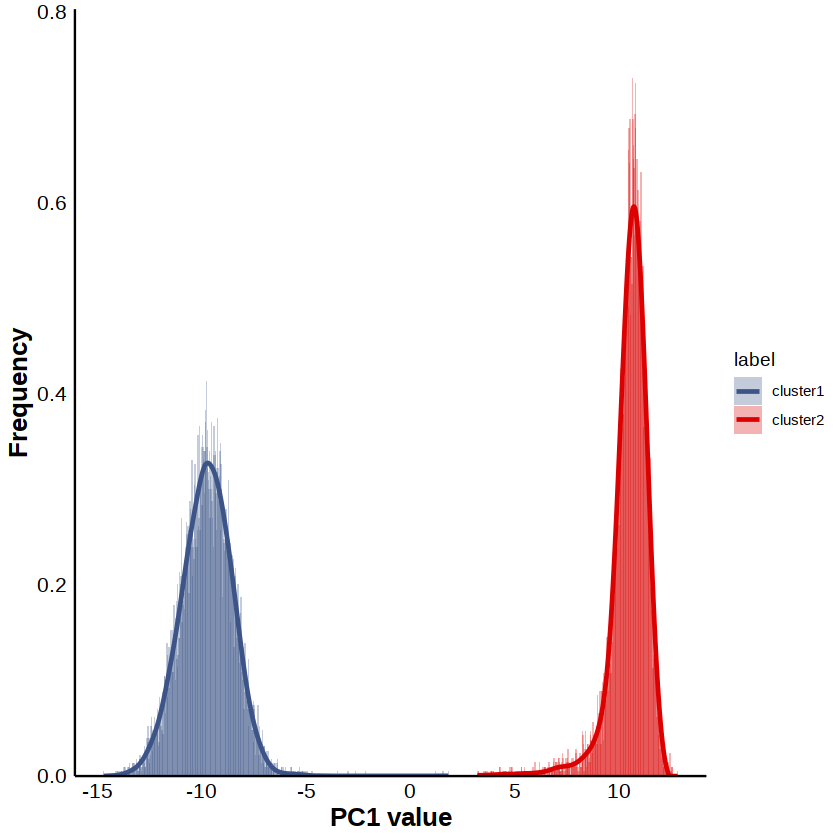

In [19]:
p.z.distribution

# PC selection

In [20]:
pc.th <- 10

In [21]:
select.pcs <- 1

In [22]:
a=Z_pca_results$sdev[1:pc.th]/sum(Z_pca_results$sdev)
b=(Z_pca_results$x)[,1:pc.th]%>%apply(2,function(x){x%>%dip.test%>%.[['statistic']]})

data.df <- cbind(a,b,0)%>%as.data.frame%>%rename_with(~c('Var','Dip','Label'))
data.df[select.pcs,'Label'] <- 1

In [23]:
data.df$Dip <- data.df$Dip / 10

In [24]:
data.df <- data.df%>%rownames_to_column('id')%>%pivot_longer(cols = Var:Dip)%>%mutate(id=gsub('PC','',id))

In [25]:
data.df$id <- factor(data.df$id, levels=c(1:pc.th))

In [26]:
data.df$value <- data.df$value * 100

In [27]:
plot.percentage <- (ggplot(data.df,aes(x=id,y=value,group=name,color=name))+geom_point(size=0.5)+
        geom_line() +
        scale_color_manual(values = colors_[c(8,4)])+
        geom_abline(slope = 0,intercept = 1,color=colors_[8],linetype=3)+
        geom_vline(xintercept = 20,color=colors_[4],linetype=3)+
        scale_y_continuous(
            "Explained Variance (%)", 
            sec.axis = sec_axis(~ . , name = "Modality Score (*0.1)")
          )+
        theme_classic()+
        xlab('PCs'))%>%scatter_style()+
        theme(axis.text.x=element_blank(),
              #axis.line.y.right = element_line(color =  colors_[8]),
              axis.ticks.y.right = element_line(color =  colors_[8]),
            axis.text.y.right = element_text(color =  colors_[8]), 
            axis.title.y.right = element_text(color =  colors_[8]),
              
            # axis.line.y.left = element_line(color = colors_[4]),
              axis.ticks.y.left = element_line(color = colors_[4]),
            axis.text.y.left = element_text(color = colors_[4]), 
            axis.title.y.left = element_text(color =colors_[4])
        )

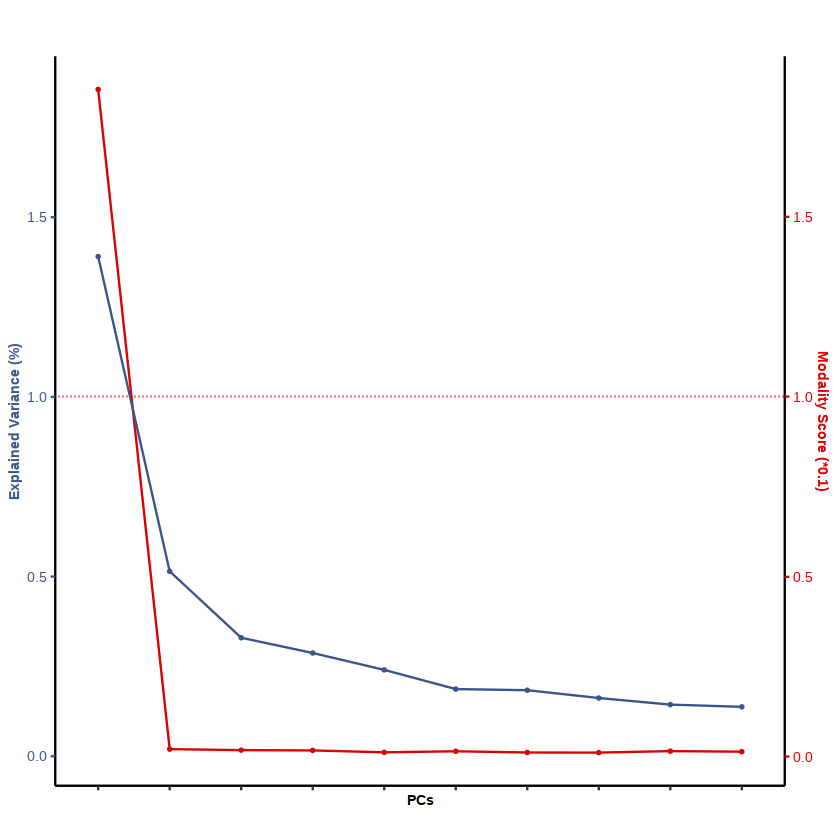

In [28]:
plot.percentage

# Generate simulation data

In [31]:
mat.sgrna <- readRDS('data/sgRNA.all.combine_K562_RPE1.rds')

In [38]:
mat.sgrna.filter <- mat.sgrna%>%filter(site!='non-targeting')%>%filter(!is.na(freq.k562))

rpe1 <- mat.sgrna.filter%>%mutate(a=ifelse(freq.rpe1>1000,1000,freq.rpe1))%>%pull(a)
k562 <- mat.sgrna.filter%>%mutate(a=ifelse(freq.k562>1000,1000,freq.k562))%>%pull(a)

mat.sgrna.filter <- mat.sgrna.filter%>%mutate(rpe1=ifelse(freq.rpe1>1000,1000,freq.rpe1),k562=ifelse(freq.k562>1000,1000,freq.k562))

In [41]:
data.rpe1.processed <- readRDS('data/data.norm.higsgRNA.rpe1.rds')
data.k562.processed <- readRDS('data/data.norm.higsgRNA.k562.rds')

In [43]:
sgrna.rpe1 <- readRDS('data/sgRNA.rpe1.assign.rds')

sgrna.k562 <- readRDS('data/sgRNA.k562.assign.rds')

In [45]:
mat.sgrna.hf <- readRDS('data/sgRNA.highCellFreq.combine_K562_RPE1.rds')
mat.sgrna.hf <- mat.sgrna.hf%>%mutate(change.final=ifelse(change.vsNT>1, change.vsNT,1/change.vsNT))

In [46]:
sites <- (mat.sgrna.hf$site)%>%as.character

In [47]:
cells.r.c <- sgrna.rpe1%>%filter(gene=='non-targeting')%>%rownames
cells.k.c <- sgrna.k562%>%filter(gene=='non-targeting')%>%rownames
Z.rpe1 = data.rpe1.processed[intersect(cells.r.c,rownames(data.rpe1.processed)),features.select]
Z.k562 = data.k562.processed[intersect(cells.k.c,rownames(data.k562.processed)),features.select]
pc.select <- 1

# simulation & performance

In [48]:
calError_fun <- function(site){
  
    cells.r <- sgrna.rpe1%>%filter(gene==site)%>%rownames
    cells.k <- sgrna.k562%>%filter(gene==site)%>%rownames
    ## projection
    Y.rpe1 = data.rpe1.processed[intersect(cells.r,rownames(data.rpe1.processed)),features.select]
    Y.k562 = data.k562.processed[intersect(cells.k,rownames(data.k562.processed)),features.select]
    Y = rbind(Y.rpe1,Y.k562)

    res.fc <- cbind(Y.rpe1%>%colMeans - Z.rpe1%>%colMeans,
                    Y.k562%>%colMeans - Z.k562%>%colMeans)%>%
              as.data.frame%>%mutate(diff=V1-V2,mean=(V1+V2)/2)
    res.fc.sub <- res.fc%>%filter(abs(diff)<0.05)%>%
                  filter(abs(V1)>0.05,abs(V2)>0.05)

    genes <- res.fc.sub%>%rownames

    # ground truth： beta
    # mean results: beta.mean.sub
    # EM results: beta.em.sub

    beta.mean <- rbind(Y.rpe1,Y.k562)%>%colMeans - rbind(Z.rpe1,Z.k562)%>%colMeans
    beta.mean.sub <- beta.mean[genes]

    beta <- res.fc %>%.[,'mean']
    beta.sub <- res.fc%>%.[genes,'mean']

    Y.proj <- Y %*% Z_projection_genebypc
    beta.pc.mean <- colMeans(Y.proj) - colMeans(Z_PC_matrix)

    
    a=get_beta_EM_sep_method(y = Y.proj[,pc.select],number.component = 2,
                        em = Z_EM_results_d1$mu, es = Z_EM_results_d1$sigma, 
                           el = Z_EM_results_d1$lambda, 
                        beta_init = beta.pc.mean[pc.select])

    beta.pc.em <- beta.pc.mean
    beta.pc.em[1] <- a$beta

    beta.em <- beta.pc.em %*% t(Z_projection_genebypc) - colMeans(Z)
    beta.mean <- beta.pc.mean %*% t(Z_projection_genebypc) - colMeans(Z)

    # a=rbind(beta.em[,genes]-beta.sub,beta.mean[,genes]-beta.sub)%>%t%>%as.data.frame
    # plot(abs(a[,1]),abs(a[,2]),cex=0.1)

    df.error <- rbind(beta.em-beta,beta.mean-beta)%>%t%>%as.data.frame%>%rename_with(~c('em','fc'))%>%
            rownames_to_column('gene')%>%mutate(feature.gene=ifelse(gene%in%genes,1,0),site=site)
    plot(df.error.tmp%>%filter(feature.gene==1)%>%pull(em),df.error.tmp%>%filter(feature.gene==1)%>%pull(fc),cex=0.1, xlab='em',ylab='fc')

    return(df.error)
    
}

In [54]:
calError_fun <- function(site){
  
    cells.r <- sgrna.rpe1%>%filter(gene==site)%>%rownames
    cells.k <- sgrna.k562%>%filter(gene==site)%>%rownames
    ## projection
    Y.rpe1 = data.rpe1.processed[intersect(cells.r,rownames(data.rpe1.processed)),features.select]
    Y.k562 = data.k562.processed[intersect(cells.k,rownames(data.k562.processed)),features.select]
    Y = rbind(Y.rpe1,Y.k562)

    res.fc <- cbind(Y.rpe1%>%colMeans - Z.rpe1%>%colMeans,
                    Y.k562%>%colMeans - Z.k562%>%colMeans)%>%
              as.data.frame%>%mutate(diff=V1-V2,mean=(V1+V2)/2)
    res.fc.sub <- res.fc%>%filter(abs(diff)<0.05)%>%
                  filter(abs(V1)>0.05,abs(V2)>0.05)

    genes <- res.fc.sub%>%rownames

    # ground truth： beta
    # mean results: beta.mean.sub
    # EM results: beta.em.sub

    beta.mean <- rbind(Y.rpe1,Y.k562)%>%colMeans - rbind(Z.rpe1,Z.k562)%>%colMeans
    beta.mean.sub <- beta.mean[genes]

    beta <- res.fc %>%.[,'mean']
    beta.sub <- res.fc%>%.[genes,'mean']

    Y.proj <- Y %*% Z_projection_genebypc
    beta.pc.mean <- colMeans(Y.proj) - colMeans(Z_PC_matrix)

    
    a=get_beta_EM_sep_method(y = Y.proj[,pc.select],number.component = 2,
                        em = Z_EM_results_d1$mu, es = Z_EM_results_d1$sigma, 
                           el = Z_EM_results_d1$lambda, 
                        beta_init = beta.pc.mean[pc.select])

    beta.pc.em <- beta.pc.mean
    beta.pc.em[1] <- a$beta

    beta.em <- beta.pc.em %*% t(Z_projection_genebypc) - colMeans(Z)
    beta.mean <- beta.pc.mean %*% t(Z_projection_genebypc) - colMeans(Z)

    # a=rbind(beta.em[,genes]-beta.sub,beta.mean[,genes]-beta.sub)%>%t%>%as.data.frame
    # plot(abs(a[,1]),abs(a[,2]),cex=0.1)

    df.error <- rbind(beta.em-beta,beta.mean-beta)%>%t%>%as.data.frame%>%rename_with(~c('em','fc'))%>%
            rownames_to_column('gene')%>%mutate(feature.gene=ifelse(gene%in%genes,1,0),site=site)
    #plot(df.error.tmp%>%filter(feature.gene==1)%>%pull(em),df.error.tmp%>%filter(feature.gene==1)%>%pull(fc),cex=0.1, xlab='em',ylab='fc')

    return(df.error)
    
}

In [55]:
library(parallel)

In [56]:
res.error <- mclapply(sites,calError_fun,mc.cores = 80)

In [57]:
df.error <- res.error%>%reduce(rbind)%>%pivot_longer(cols = c('em','fc'))%>%mutate(error=abs(value))